In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
from keras.utils import np_utils


from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, robust_scale, RobustScaler
from sklearn.pipeline import Pipeline

def simpleAccuracy(pred, dummy_y):
    pred_Y = np.argmax(pred, axis=1)
    true_Y = np.argmax(dummy_y, axis=1)
    
    # this gives the measure of correctly tagged events, over the total
    return sum(pred_Y == true_Y)/len(true_Y)

In [3]:


variables = [
    ## best results with all variables, but should get pruned at some point...
    'n_jet',
    'n_central',
    #'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
    'lead_jet_eta',
    'sublead_jet_eta',
    'lead_btag_pt',
    'sublead_btag_pt',
    'lead_btag_eta',
    'sublead_btag_eta',
    'min_bl_dR',
    ##'weight', # this does of course _not_ work 🤡 
]

In [4]:
## filter some data
df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py

df_MG = pd.read_hdf('data/multiclass_input_loose_MG.h5')

preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))
#preselection = ((df['n_jet']>2) & (df['n_btag']>0)) # redundant selection, but we can filter on top


df = df[preselection]
df_MG = df_MG[preselection]

## cranking up stats by a mere 70% is not really worth it...
#frames = [df, df_MG]
#df_train = pd.concat(frames)

# maybe less overtraining??
df_train = df

labels = df['label'].values
labels_train = df_train['label'].values

X = df_train[(labels_train<5)][variables]
labels_train = labels_train[labels_train<5]

labels = labels[labels<5]

<ipython-input-4-27a463ec029e>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_MG = df_MG[preselection]


In [5]:
print ("Number of non-prompt events (=ttbar):", len(df[df['label']==4]))

Number of non-prompt events (=ttbar): 1724


In [6]:
df

,mjj_max,delta_eta_jj,met,ht,st,n_jet,n_btag,n_fwd,n_central,n_tau,...,sublead_lep_pt,sublead_lep_eta,sublead_lep_phi,sublead_lep_charge,dilepton_mass,dilepton_pt,min_bl_dR,min_mt_lep_met,label,weight
2,194.105621,1.260254,74.373802,262.125000,430.023193,4.0,1.0,1.0,4.0,1.0,...,40.998814,-1.281250,1.844971,-1.0,107.509613,60.145172,1.259133,72.992027,5.0,0.000040
3,354.433075,2.412842,70.159790,349.093750,523.315552,4.0,1.0,1.0,3.0,1.0,...,31.747696,2.341797,-0.483154,-1.0,32.560280,99.738411,1.870951,92.634171,5.0,0.000056
6,290.271454,2.643188,70.001572,323.656250,451.389374,4.0,1.0,1.0,4.0,1.0,...,28.273561,-0.105957,1.872803,-1.0,50.063515,35.277813,0.641664,25.954891,5.0,0.000086
7,157.515152,1.109863,41.140411,201.015625,323.658203,4.0,1.0,1.0,4.0,1.0,...,30.392860,1.449463,-2.618164,1.0,18.275454,81.101807,1.171399,41.923019,5.0,0.000043
8,426.071411,4.686035,6.460495,228.312500,358.505798,5.0,1.0,1.0,4.0,2.0,...,43.126644,-1.731445,-2.075195,-1.0,106.548592,67.040459,1.249649,10.100463,5.0,0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556669,475.289917,4.175781,94.778648,267.343750,510.779083,5.0,1.0,1.0,4.0,2.0,...,49.935333,2.100098,0.478027,-1.0,192.048096,52.077545,0.910176,50.270657,0.0,0.000003
556672,897.106445,3.582275,73.078827,742.531250,1144.180420,7.0,3.0,1.0,7.0,2.0,...,42.697544,-1.248779,1.184814,-1.0,134.260300,311.545471,2.672923,81.324379,0.0,0.000004
556673,1965.655640,6.787598,119.449890,479.656250,696.492737,8.0,1.0,2.0,4.0,1.0,...,34.135391,1.772705,-0.797729,-1.0,247.865540,89.633331,0.607082,104.620667,0.0,0.000003
556674,590.984741,3.446289,34.986790,614.156250,823.044861,8.0,2.0,2.0,7.0,1.0,...,38.037109,0.702271,1.138184,-1.0,148.636368,134.124115,1.047890,13.209949,0.0,0.000002


In [7]:
encoder = LabelEncoder()
encoder.fit(labels_train)
dummy_y = np_utils.to_categorical(labels_train)

dummy_y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [9]:
robust = False

if not robust:
    X_mean, X_std = X.mean(), X.std()

    X_norm = copy.deepcopy(X)
    X_norm -= X_mean
    X_norm /= X_std

else:
    X_norm = robust_scale(X, quantile_range=(10.0, 90.0))

X_norm = np.nan_to_num(X_norm, 0) # this happens in like 10 events
X_norm

array([[ 0.04969792,  0.80178592, -0.7634506 , ...,  0.65490174,
         1.56692216,  0.74491573],
       [-1.24649675, -1.24866797,  0.60907918, ...,  1.7734658 ,
         1.66022541,  0.56809661],
       [ 0.04969792,  0.80178592, -0.7634506 , ..., -0.83291913,
         0.60676657, -0.50177101],
       ...,
       [ 1.34589259, -0.56518334, -0.7634506 , ...,  1.24173601,
         0.40849715, -1.28484731],
       [ 1.34589259,  1.48527055, -0.7634506 , ..., -0.08451134,
         0.47187465, -0.57658287],
       [-0.59839942,  0.11830129, -0.7634506 , ..., -0.79447855,
        -0.07846312, -1.58789407]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, train_size= int( 0.9*dummy_y.shape[0] ), random_state=42 )

In [11]:
np.unique(y_train, axis=0)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [12]:
from sklearn.utils import compute_class_weight

y_train_int = np.argmax(y_train, axis=1) # back to integers from one hot
y_test_int = np.argmax(y_test, axis=1) # back to integers from one hot

classWeight = compute_class_weight('balanced', classes=np.unique(y_train_int, axis=0), y=y_train_int) 
classWeight = dict(enumerate(classWeight))
classWeight

{0: 0.4760126393312102,
 1: 1.0071011212296679,
 2: 0.8118950115640052,
 3: 1.5770432345546717,
 4: 24.702259522272435}

In [27]:
input_dim = len(variables)
out_dim = len(dummy_y[0])

# define baseline model
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(2*input_dim, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(2*input_dim, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    
    #opt = tf.keras.optimizers.SGD(lr=0.1)
    #opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    opt = tf.keras.optimizers.RMSprop(lr=0.001) ## performs best.
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model
 

model = baseline_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 54)                1512      
_________________________________________________________________
batch_normalization_8 (Batch (None, 54)                216       
_________________________________________________________________
dropout_8 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 54)                2970      
_________________________________________________________________
batch_normalization_9 (Batch (None, 54)                216       
_________________________________________________________________
dropout_9 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                

In [28]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('NN', baseline_model()),
])

In [29]:
df_train['weight'].values

array([4.03980684e-05, 5.63810634e-05, 8.63536505e-05, ...,
       3.25269807e-06, 2.32720663e-06, 2.67101728e-06])

In [30]:
from ML.lrcurve import KerasLearningCurve

epochs = 50
batch_size = 5120
#batch_size = 1000
validation_split = 0.2


history = pipe.fit(
    X_train,
    y_train,
    NN__epochs = epochs,
    NN__batch_size = batch_size,
    NN__validation_split = validation_split,
    NN__verbose = 0,
    #NN__class_weight = classWeight,
    NN__sample_weight = df_train['weight'].values,
    NN__callbacks = [KerasLearningCurve()]
)

In [13]:

if not robust:
    X_all = df[variables].values
    X_all -= X_mean
    X_all /= X_std
else:
    X_all = robust_scale(df[variables].values, quantile_range=(10.0, 90.0))
    
pred_all = model.predict( X_all )
pred_train = model.predict( X_train )
pred_test = model.predict( X_test )
pred_all[:,0]

array([0.08982792, 0.08895004, 0.08819555, ..., 0.45341817, 0.34088668,
       0.19930635], dtype=float32)

In [31]:
pipe.predict(X_test)

array([[0.5069671 , 0.1319154 , 0.21373641, 0.13281856, 0.01456246],
       [0.07659499, 0.7359119 , 0.03782035, 0.14675851, 0.00291428],
       [0.24275728, 0.19248322, 0.38796288, 0.15915613, 0.01764044],
       ...,
       [0.45550752, 0.29206508, 0.22779812, 0.02357082, 0.00105839],
       [0.21101835, 0.40965998, 0.25753608, 0.11577534, 0.00601024],
       [0.61280507, 0.09580374, 0.14703587, 0.14299072, 0.00136458]],
      dtype=float32)

In [36]:
pred_all

array([[0.08982792, 0.34274387, 0.11951886, 0.22872545, 0.21918394],
       [0.08895004, 0.19843853, 0.15506355, 0.11676873, 0.4407791 ],
       [0.08819555, 0.17829394, 0.10400631, 0.28092167, 0.3485825 ],
       ...,
       [0.45341817, 0.11330319, 0.20676903, 0.09917057, 0.127339  ],
       [0.34088668, 0.18047556, 0.15198447, 0.26726002, 0.05939331],
       [0.19930635, 0.18658683, 0.12636532, 0.3596809 , 0.12806061]],
      dtype=float32)

In [14]:
df['score_topW'] = pred_all[:,0]
df['score_ttW'] = pred_all[:,1]
df['score_ttZ'] = pred_all[:,2]
df['score_ttH'] = pred_all[:,3]
df['score_ttbar'] = pred_all[:,4]
df['score_best'] = np.argmax(pred_all, axis=1)

In [22]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from coffea import processor, hist
from processor.std_acumulators import *

from plots.helpers import *

score_axis              = hist.Bin("score",          r"N", 20, 0, 1)
score_axis_v2           = hist.Bin("score",          r"N", 8, 0.2, 0.60)
#score_axis_v2           = hist.Bin("score",          r"N", 4, 0.2, 0.6)
p_axis                  = hist.Bin("p",             r"$p$ (GeV)", 10, 0, 3500)

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
#p_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
score_bins_coarse = hist.Bin('score', 'score', 10, 0, 1)
eta_bins = hist.Bin('eta', r'$\eta $', 50, -5.0, 5.0)

In [23]:
processes = {
    'topW_v2': df[df['label']==0],
    'TTW': df[df['label']==1],
    'TTZ': df[df['label']==2],
    'TTH': df[df['label']==3],
    'ttbar': df[df['label']==4],
    'rare': df[df['label']==5],
}

sel_SR = ((df['n_jet']>0) & (df['n_central']>0) & (df['n_lep_tight']==2) & (df['n_fwd']>0) & (df['met']>50))

sel_topW = ((df['score_best']==0) & (df['n_lep_tight']==2) & (df['n_fwd']>0) & (df['met']>50))
sel_baseline = ((df['n_jet']>4) & (df['n_central']>3) & (df['met']>50) & (df['st']>600) & (df['n_fwd']>0) & (df['met']>50))

sel_topW_pos = (sel_topW & (df['lead_lep_charge']>0))
sel_topW_neg = (sel_topW & (df['lead_lep_charge']<0))

sel_ttW = ((df['score_best']==1))
sel_ttZ = ((df['score_best']==2))
sel_ttH = ((df['score_best']==3))
sel_ttbar = ((df['score_best']==4))

h_best_score = hist.Hist("best_score", dataset_axis, multiplicity_axis)
h_score_topW = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_Run3 = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_pos = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_neg = hist.Hist("score", dataset_axis, score_axis_v2)
h_score = hist.Hist("score", dataset_axis, score_axis)
h_jet_pt = hist.Hist("jet_pt", dataset_axis, pt_axis)
h_fwd_p = hist.Hist("fwd_p", dataset_axis, p_axis)


for proc in processes:
    h_best_score.fill(dataset=proc, multiplicity=processes[proc][sel_SR]['score_best'].values, weight=processes[proc][sel_SR]['weight'].values*137)
    h_score_topW.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*137)
    h_score_topW_Run3.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*300)
    h_score_topW_pos.fill(dataset=proc, score=processes[proc][sel_topW_pos]["score_topW"].values, weight=processes[proc][sel_topW_pos]["weight"].values*137)
    h_score_topW_neg.fill(dataset=proc, score=processes[proc][sel_topW_neg]["score_topW"].values, weight=processes[proc][sel_topW_neg]["weight"].values*137)
    
    h_score.fill(dataset=proc, score=processes[proc][sel_SR]["score_topW"].values, weight=processes[proc][sel_SR]["weight"].values*137)
    h_jet_pt.fill(dataset=proc, pt=processes[proc][sel_topW]["lead_jet_pt"].values, weight=processes[proc][sel_topW]["weight"].values*137)
    h_fwd_p.fill(dataset=proc, p=processes[proc][sel_baseline]["fwd_jet_p"].values, weight=processes[proc][sel_baseline]["weight"].values*137)

In [24]:
output = {
    'best_score': h_best_score,
    'score_topW': h_score_topW,
    'score_topW_Run3': h_score_topW_Run3,
    'score_topW_pos': h_score_topW_pos,
    'score_topW_neg': h_score_topW_neg,
    'score': h_score,
    'jet_pt': h_jet_pt,
    'fwd_p': h_fwd_p,
}

Data: 0 MC: 654.47


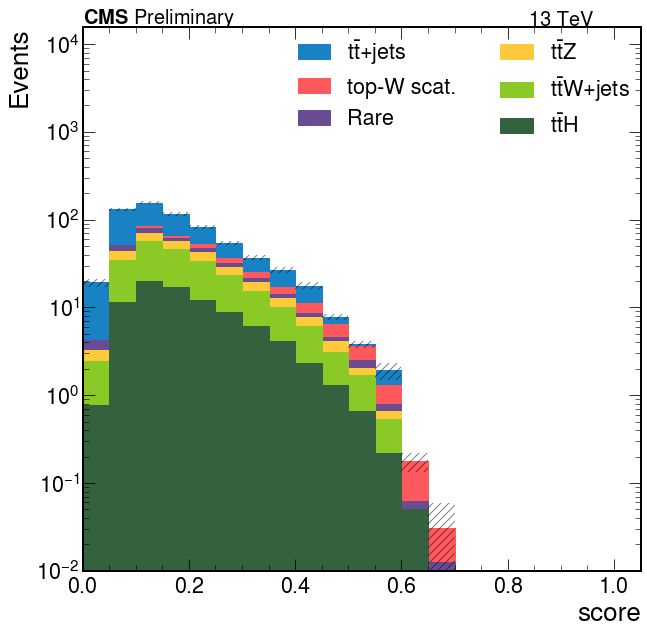

In [25]:
makePlot(output, 'score', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=True, normalize=False, axis_label='score',
        )

Data: 0 MC: 654.47


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/score_topW_shape


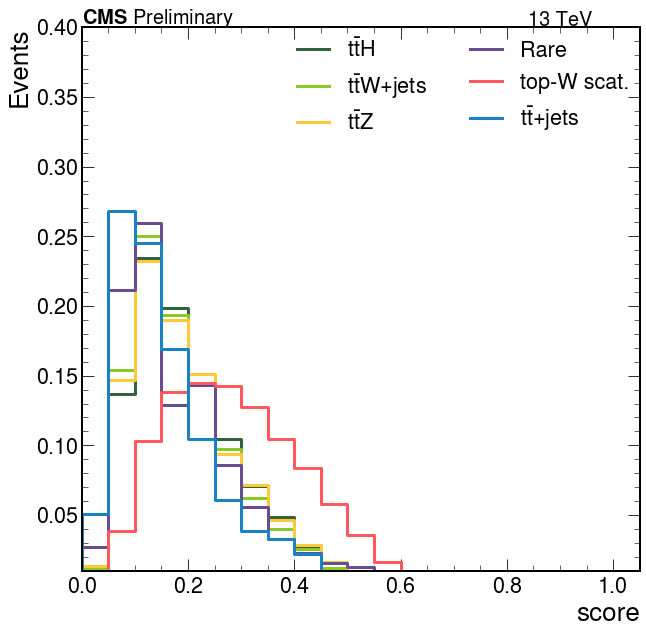

In [26]:
makePlot(output, 'score', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=False, axis_label='score',
         shape=True, ymax=0.4,
         save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/score_topW_shape'
        )

Data: 0 MC: 63.39


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/score_topW_pos_node0


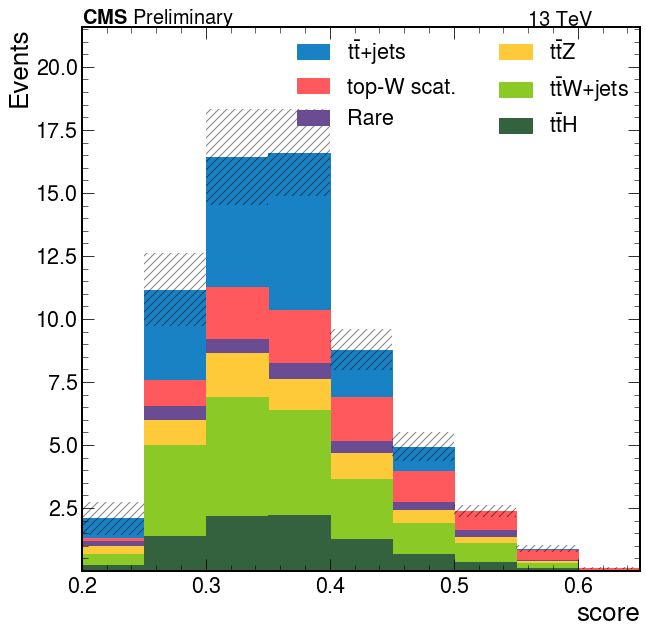

In [33]:
makePlot(output, 'score_topW_pos', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=False, axis_label='score',
         save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/score_topW_pos_node0'
        )

Data: 0 MC: 110.83


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/score_topW_node0


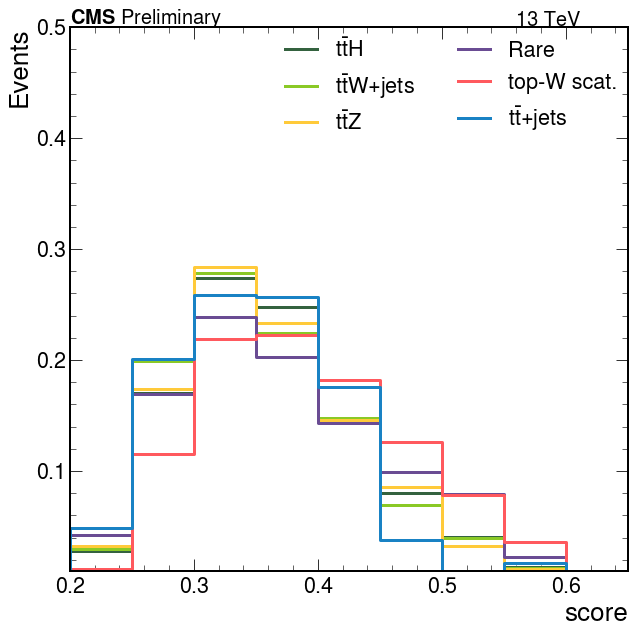

In [32]:
makePlot(output, 'score_topW', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=False, axis_label='score',
         shape=True, ymax=0.5,
         save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/score_topW_node0'
        )

Data: 0 MC: 110.83


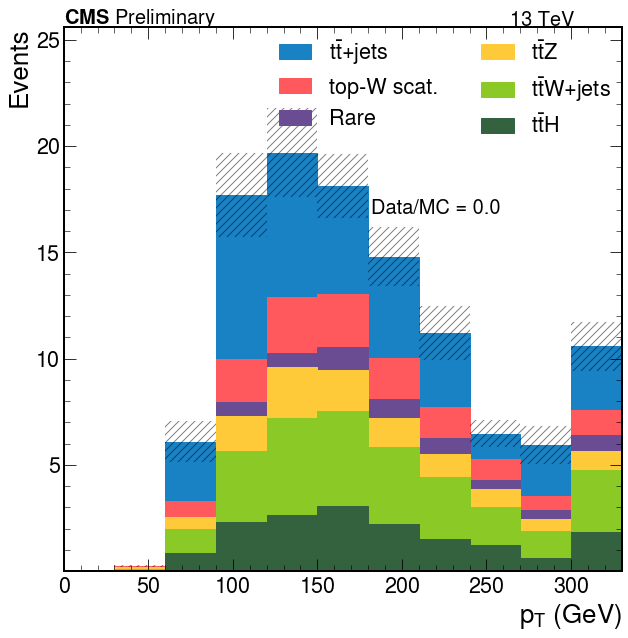

In [37]:
makePlot(output, 'jet_pt', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T\ (GeV)$',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

Data: 0 MC: 284.68


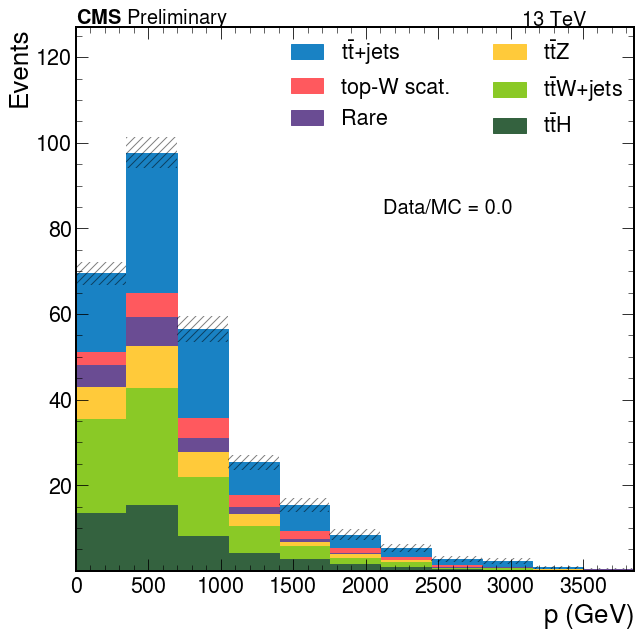

In [38]:
makePlot(output, 'fwd_p', 'p',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label=r'$p\ (GeV)$',
         #shape=True, ymax=0.4,
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

In [39]:
n_topW = h_score_topW['topW_v2'].sum('score', overflow='over').sum('dataset', overflow='over').values(overflow='over')[()]
n_all = h_score_topW.sum('score', overflow='over').sum('dataset', overflow='over').values(overflow='over')[()]

n_topW/(n_all-n_topW)

0.14514192947279833

In [40]:
h_score_topW.sum('score', overflow='over').values(overflow='over')

{('topW_v2',): 14.046904237540375,
 ('TTW',): 26.17065798512938,
 ('TTZ',): 11.488346330365815,
 ('TTH',): 16.218250285077936,
 ('ttbar',): 37.31925708573728,
 ('rare',): 5.5839589093554975}

In [41]:
df[((df['label']==0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>0.35) & (df['n_fwd']>0) & (df['met']>50))]['weight'].sum()*60

4.024344557785092

In [42]:
df[((df['label']>0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>0.35) & (df['n_fwd']>0) & (df['met']>50))]['weight'].sum()*60

21.354847139442604

In [43]:
def get_S_over_B(cut):
    sig = df[((df['label']==0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['met']>50) & (df['score_topW']>cut))]['weight'].sum()*137
    bkg = df[((df['label']>0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['met']>50) & (df['score_topW']>cut))]['weight'].sum()*137
    print ("Cut: %.2f, Signal: %.2f, Background %.2f --> S/B: %.2f"%(cut,sig,bkg,sig/bkg))
    return sig/bkg

In [44]:
get_S_over_B(0.35)

Cut: 0.35, Signal: 9.19, Background 48.76 --> S/B: 0.19


0.188451105807828

In [109]:
for x in range(100):
    get_S_over_B(x/100)

Cut: 0.00, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.01, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.02, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.03, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.04, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.05, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.06, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.07, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.08, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.09, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.10, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.11, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.12, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.13, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.14, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.15, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.16, Signal: 17.63, Background 120.46 --> S/B: 0.15
Cut: 0.17, Sig

In [30]:
df[((df['label']==0))]['weight'].sum()*137

39.032690450430394

In [31]:
df[((df['label']>0))]['weight'].sum()*137

883.0317988565668

Data: 0 MC: 654.47


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/nodes


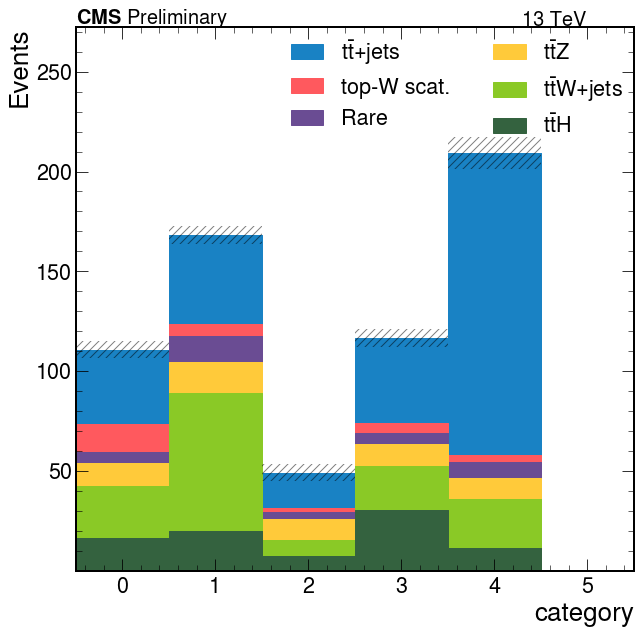

In [45]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=False, axis_label='category',
         save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier/nodes'
        )

Data: 0 MC: 654.47


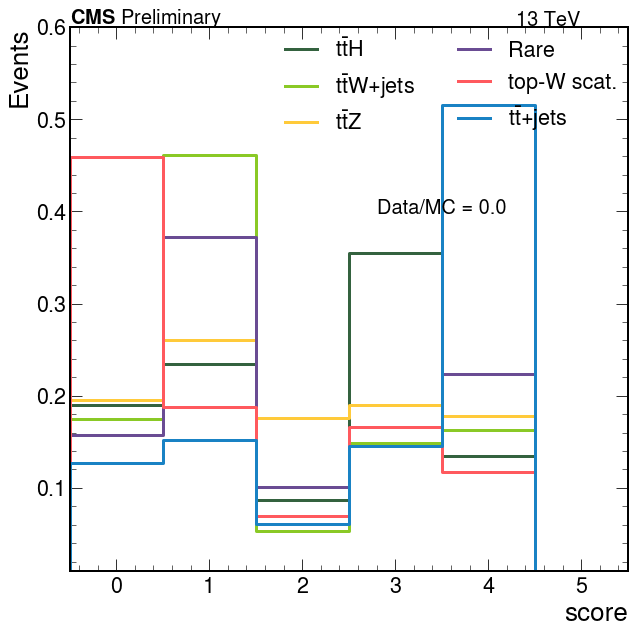

In [46]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='score', shape=True, ymax=0.6,
        )

In [50]:
from Tools.dataCard import dataCard
from Tools.limits import makeCardFromHist

SR_card = makeCardFromHist(output, 'score_topW', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_Run3 = makeCardFromHist(output, 'score_topW_Run3', nonprompt_scale=0.5, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_pos = makeCardFromHist(output, 'score_topW_pos', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_neg = makeCardFromHist(output, 'score_topW_neg', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)

SR_card_BL = makeCardFromHist(output, 'fwd_p', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_stat = makeCardFromHist(output, 'score_topW', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='_stat', systematics=False)

Writing cards using histogram: score_topW
Signal expectation:           14.05
Non-prompt background:        37.32
t(t)X(X)/rare background:     59.46
Observation:                  110.83
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/score_topW_card.txt
Writing cards using histogram: score_topW_Run3
Signal expectation:           30.76
Non-prompt background:        40.86
t(t)X(X)/rare background:     130.21
Observation:                  201.83
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/score_topW_Run3_card.txt
Writing cards using histogram: score_topW_pos
Signal expectation:           9.53
Non-prompt background:        18.67
t(t)X(X)/rare background:     35.19
Observation:                  63.39
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Wri

In [51]:
card = dataCard()

In [52]:
results = card.nllScan(SR_card, rmin=0, rmax=3, npoints=61)
results_Run3 = card.nllScan(SR_card_Run3, rmin=0, rmax=3, npoints=61)
results_stat = card.nllScan(SR_card_stat, rmin=0, rmax=3, npoints=61)
results_BL = card.nllScan(SR_card_BL, rmin=0, rmax=3, npoints=61)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/67cafa7b-5d82-46da-be25-c48abd7b07a8
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/eebd076c-3c1a-4a9f-9ecf-3b869fc580f4
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/8b19a517-cc5a-4285-a0f1-5ad6bd93eab0
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/a57cdd74-3ef9-40e0-be3a-2bd80d2ee11d


In [53]:
SR_card_opt = card.combineCards({'pos': SR_card_pos, 'neg':SR_card_neg})
results_opt = card.nllScan(SR_card_opt, rmin=0, rmax=3, npoints=61)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/2af09d19-c1c7-4f18-9622-8b3507576ad0
Copying card file to temp: score_topW_pos_card.txt
Copying card file to temp: score_topW_neg_card.txt
 dc_pos=score_topW_pos_card.txt dc_neg=score_topW_neg_card.txt
Executing cd /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/2af09d19-c1c7-4f18-9622-8b3507576ad0; eval `scramv1 runtime -sh`; combineCards.py  dc_pos=score_topW_pos_card.txt dc_neg=score_topW_neg_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/2eb2042f-2a67-47b2-aff0-126bb55b0cc1


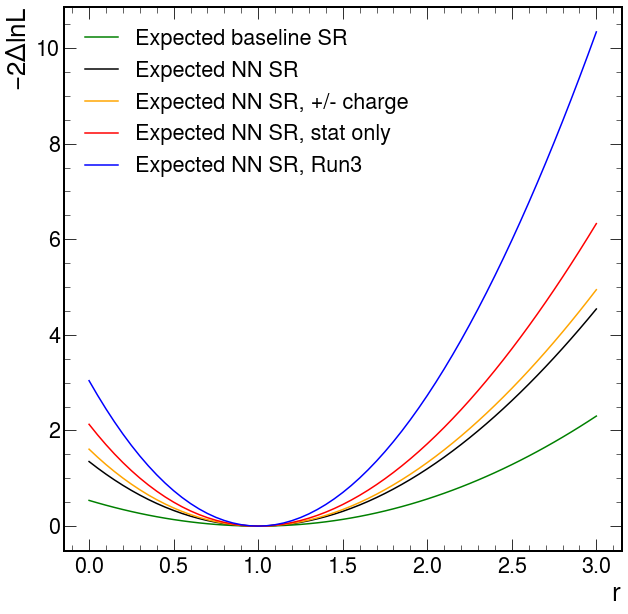

In [54]:
import mplhep
plt.style.use(mplhep.style.CMS)

plt.figure()

plt.plot(results_BL['r'][1:], results_BL['deltaNLL'][1:]*2, label=r'Expected baseline SR', c='green')
plt.plot(results['r'][1:], results['deltaNLL'][1:]*2, label=r'Expected NN SR', c='black')
plt.plot(results_opt['r'][1:], results_opt['deltaNLL'][1:]*2, label=r'Expected NN SR, +/- charge', c='orange')
plt.plot(results_stat['r'][1:], results_stat['deltaNLL'][1:]*2, label=r'Expected NN SR, stat only', c='red')
plt.plot(results_Run3['r'][1:], results_Run3['deltaNLL'][1:]*2, label=r'Expected NN SR, Run3', c='blue')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [55]:
results_opt[results_opt['r']==0]['deltaNLL']*2

<Array [1.61] type='1 * float32'>

In [56]:
results[results['r']==0]['deltaNLL']*2

<Array [1.35] type='1 * float32'>

## Some results (manual database)

Table

| selection | deltaNLL for r=0 |
| --------- | ---------------- |
| NN        | 1.42             |
| charge split | 1.59          | 
| NN + MET | 1.37 |
| charge + MET | 1.48 |


--> Explicit MET cut degrades performance. Is it really needed to veto DY?



In [171]:
np.sqrt(1.48)

1.2165525060596438

In [107]:
card.cleanUp()

Deleting:  8e65ff73-c22b-43e9-bf68-3bd86672248c
Deleting:  9ce67611-7b82-4a95-b4b1-2b772d9a6f4e
Deleting:  6ec0423a-b9d7-434c-87b8-71803871c394
Deleting:  cee934a7-7ef0-4a3c-b61d-d7a17b4b4507
Deleting:  33280281-941b-4cf8-a4f1-4fa7c8660c5e


# Stats

In [47]:
import scipy
from yahist import Hist1D


In [48]:
colors = ['gray', 'blue', 'red', 'green', 'orange']

bins = [x/20 for x in range(21)]

def test_train(test, train, y_test, y_train, labels=[], bins=25, node=0):
    h = {}
    for i, label in enumerate(labels):
        
        _ks, _p = scipy.stats.kstest(
            train[:,node][(y_train==i)],
            test[:,node][(y_test==i)]
        )
        
        h[label+'_test'] = Hist1D(test[:,node][(y_test==i)], bins=bins).normalize()
        h[label+'_train'] = Hist1D(train[:,node][(y_train==i)], bins=bins, label=label+' (p=%.2f, KS=%.2f)'%(_p, _ks)).normalize()
        

        h[label+'_test'].plot(color=colors[i], histtype="step", ls='--', linewidth=2)
        h[label+'_train'].plot(color=colors[i], histtype="step", linewidth=2)
        
def test_train_cat(test, train, y_test, y_train, labels=[], n_cat=5):
    bins = [x-0.5 for x in range(n_cat+1)]
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    
    h = {}
    for i, label in enumerate(labels):
        
        _ks, _p = scipy.stats.kstest(
            np.argmax(train, axis=1)[(y_train==i)],
            np.argmax(test, axis=1)[(y_test==i)]
        )
        
        h[label+'_test'] = Hist1D(np.argmax(test, axis=1)[(y_test==i)], bins=bins).normalize()
        h[label+'_train'] = Hist1D(np.argmax(train, axis=1)[(y_train==i)], bins=bins, label=label+' (p=%.2f, KS=%.2f)'%(_p, _ks)).normalize()
        

        h[label+'_test'].plot(color=colors[i], histtype="step", ls='--', linewidth=2)
        h[label+'_train'].plot(color=colors[i], histtype="step", linewidth=2)
        
    ax.set_ylabel('a.u.')
    ax.set_xlabel('category')

    ax.set_ylim(0,1/n_cat*5)

    
def get_ROC(test, train, y_test, y_train, node=0):

    y_test_binary = (y_test!=node)*0 + (y_test==node)*1

    fpr_test, tpr_test, thresholds_test = roc_curve( y_test_binary, test[:,node] )
    auc_val_test = auc(fpr_test, tpr_test)

    plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))

    y_train_binary = (y_train!=node)*0 + (y_train==node)*1
    
    fpr_train, tpr_train, thresholds_test = roc_curve( y_train_binary, train[:,node]  )
    auc_val_train = auc(fpr_train, tpr_train)

    plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))

    plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
    plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
    plt.legend(loc ='lower left')

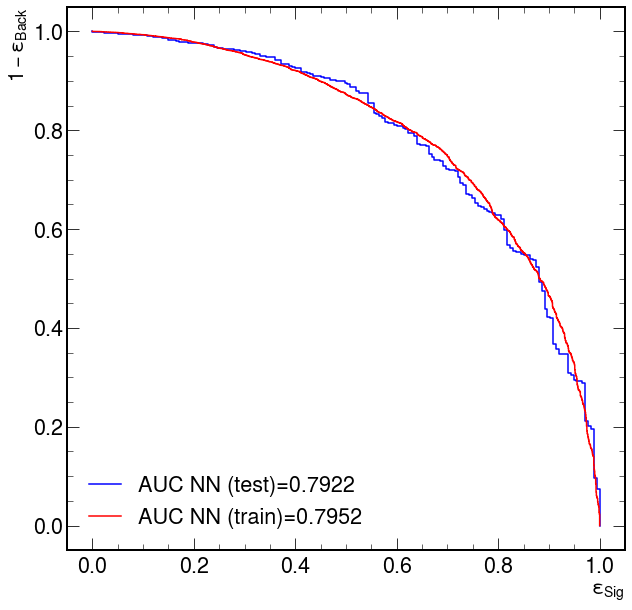

In [49]:
get_ROC(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    node=4,
)

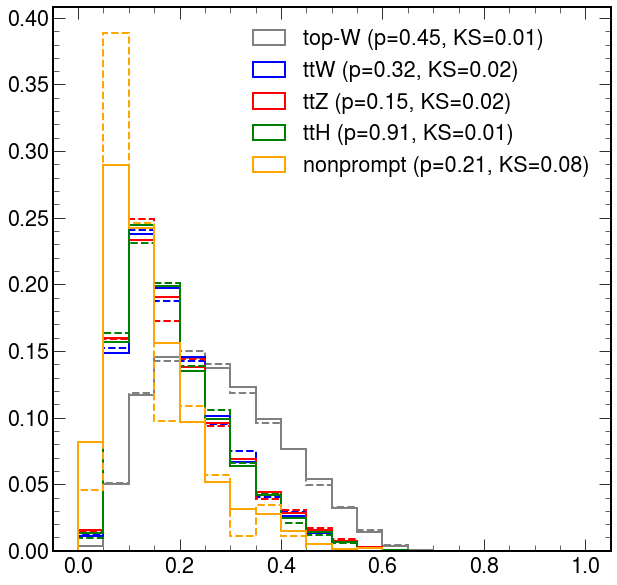

In [57]:
test_train(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    labels=['top-W', 'ttW', 'ttZ', 'ttH', 'nonprompt'],
    node=0,
    bins=bins,
)

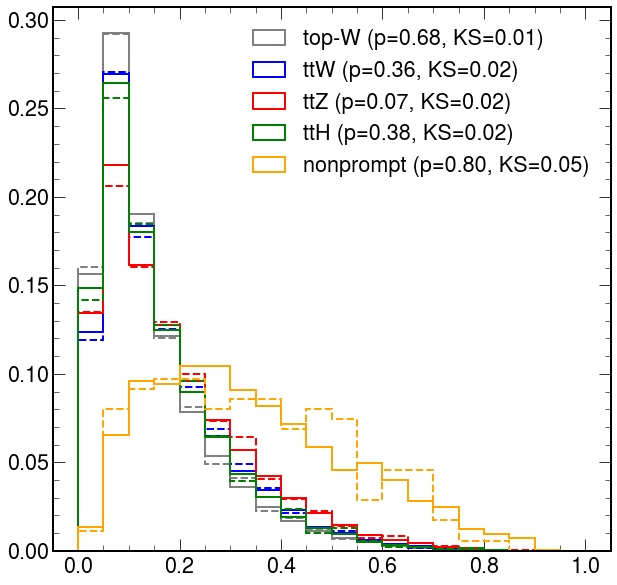

In [58]:
test_train(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    labels=['top-W', 'ttW', 'ttZ', 'ttH', 'nonprompt'],
    node=4,
    bins=bins,
)

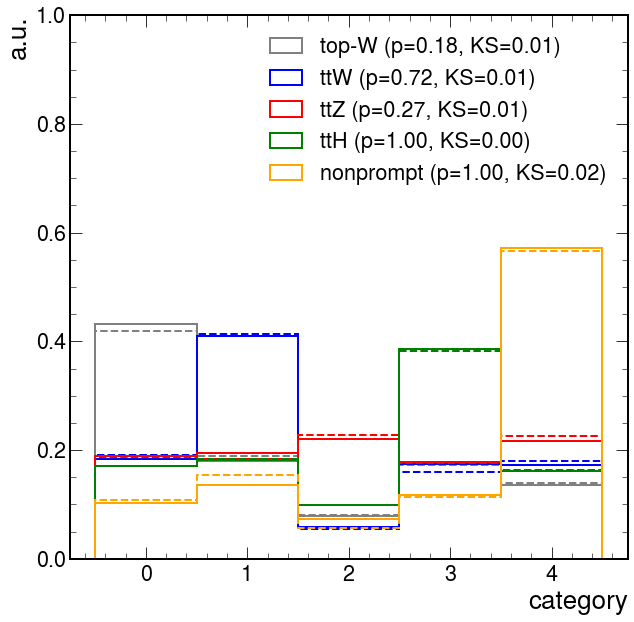

In [59]:
test_train_cat(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    labels=['top-W', 'ttW', 'ttZ', 'ttH', 'nonprompt'],
    n_cat=5,
)

In [66]:
def get_correlation_matrix(df):

    fig = plt.figure(figsize=(19, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

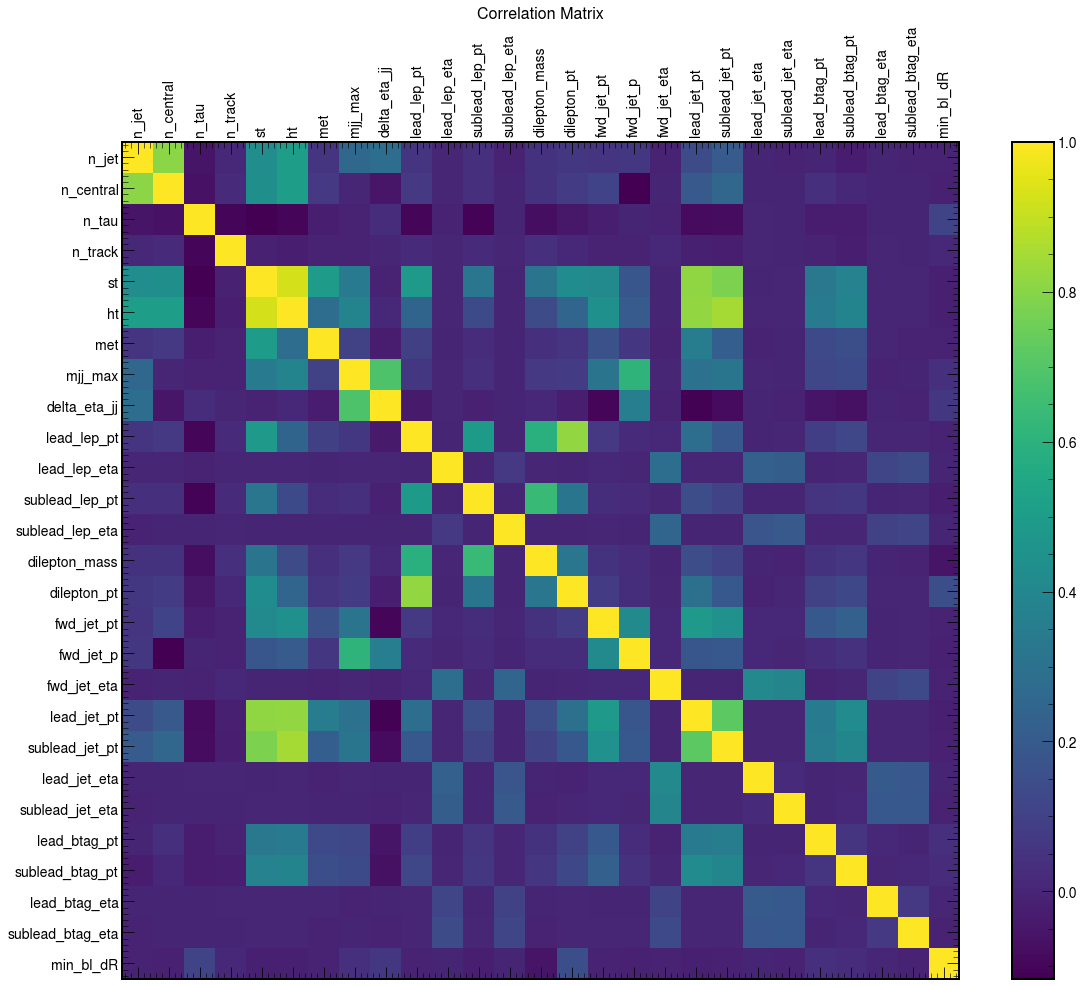

In [67]:
get_correlation_matrix(df[((df['label']==0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))][variables])

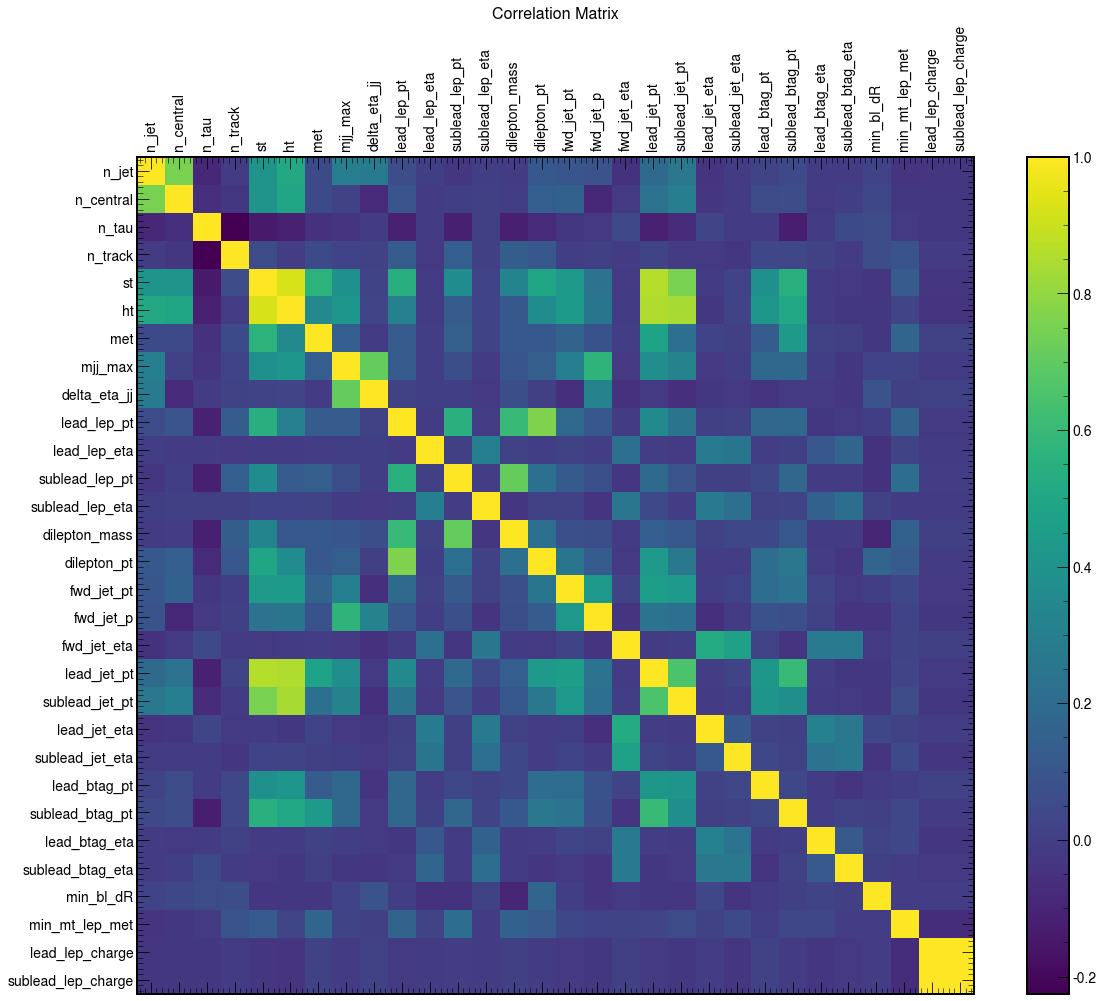

In [73]:
get_correlation_matrix(df[((df['label']==4) & (df['n_lep_tight']==2) & (df['n_fwd']>0))][variables+['min_mt_lep_met', 'lead_lep_charge', 'sublead_lep_charge']])

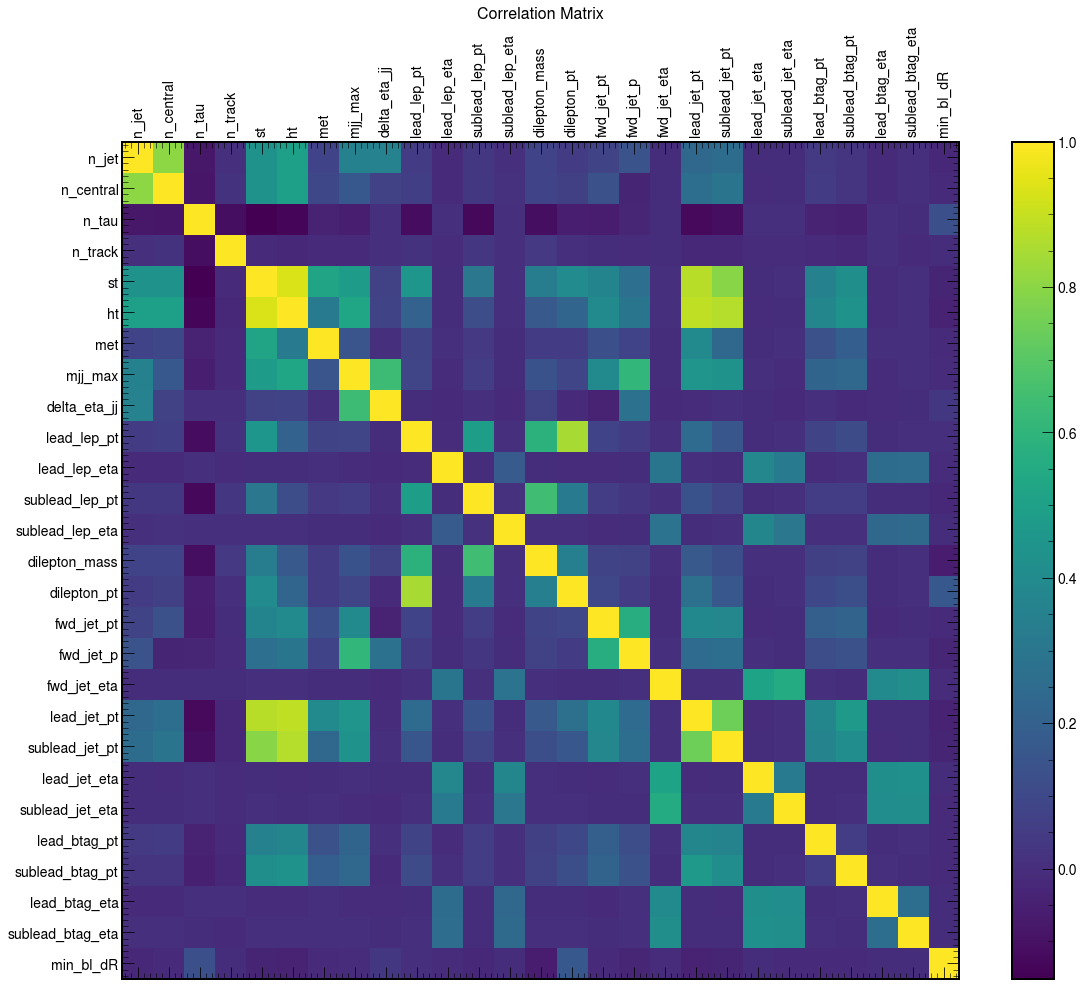

In [69]:
get_correlation_matrix(df[((df['label']==1) & (df['n_lep_tight']==2) & (df['n_fwd']>0))][variables])

In [74]:
corr = df[((df['label']==0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))][variables+['min_mt_lep_met', 'lead_lep_charge', 'sublead_lep_charge']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,n_jet,n_central,n_tau,n_track,st,ht,met,mjj_max,delta_eta_jj,lead_lep_pt,lead_lep_eta,sublead_lep_pt,sublead_lep_eta,dilepton_mass,dilepton_pt,fwd_jet_pt,fwd_jet_p,fwd_jet_eta,lead_jet_pt,sublead_jet_pt,lead_jet_eta,sublead_jet_eta,lead_btag_pt,sublead_btag_pt,lead_btag_eta,sublead_btag_eta,min_bl_dR,min_mt_lep_met,lead_lep_charge,sublead_lep_charge
n_jet,1.00,0.81,-0.05,0.01,0.43,0.51,0.05,0.26,0.29,0.06,0.00,0.04,-0.00,0.05,0.06,0.05,0.06,-0.00,0.14,0.20,-0.00,-0.00,-0.00,-0.03,-0.00,-0.00,-0.01,-0.01,0.02,0.02
n_central,0.81,1.00,-0.06,0.02,0.44,0.51,0.07,0.00,-0.05,0.07,0.00,0.04,-0.00,0.05,0.08,0.11,-0.12,-0.00,0.20,0.25,-0.00,0.00,0.04,0.01,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00
n_tau,-0.05,-0.06,1.00,-0.10,-0.11,-0.10,-0.02,-0.01,0.02,-0.10,-0.01,-0.10,0.00,-0.07,-0.04,-0.02,-0.00,-0.01,-0.09,-0.08,0.00,-0.00,-0.03,-0.03,-0.00,-0.00,0.11,-0.02,-0.00,-0.00
n_track,0.01,0.02,-0.10,1.00,-0.01,-0.02,-0.01,-0.01,0.00,0.02,0.00,0.02,0.01,0.03,0.01,-0.00,-0.01,0.01,-0.02,-0.02,0.00,-0.00,-0.01,-0.02,0.00,-0.00,0.01,0.01,0.00,0.00
st,0.43,0.44,-0.11,-0.01,1.00,0.93,0.50,0.35,-0.01,0.49,0.00,0.32,-0.00,0.31,0.43,0.41,0.18,-0.00,0.82,0.78,0.00,0.00,0.33,0.38,0.00,0.00,-0.02,0.09,0.04,0.04
ht,0.51,0.51,-0.10,-0.02,0.93,1.00,0.28,0.39,0.01,0.24,0.00,0.13,-0.00,0.14,0.25,0.45,0.20,-0.00,0.82,0.85,0.00,0.00,0.35,0.39,0.00,0.00,-0.02,0.00,0.04,0.04
met,0.05,0.07,-0.02,-0.01,0.50,0.28,1.00,0.10,-0.03,0.10,-0.00,0.02,-0.00,0.03,0.05,0.16,0.06,-0.01,0.36,0.22,-0.01,0.00,0.13,0.15,0.00,-0.00,-0.00,0.20,0.04,0.04
mjj_max,0.26,0.00,-0.01,-0.01,0.35,0.39,0.10,1.00,0.69,0.07,0.00,0.04,-0.00,0.07,0.08,0.31,0.61,0.00,0.30,0.32,0.01,-0.00,0.12,0.13,-0.00,-0.00,0.04,0.01,0.05,0.05
delta_eta_jj,0.29,-0.05,0.02,0.00,-0.01,0.01,-0.03,0.69,1.00,-0.03,0.00,-0.01,-0.00,0.01,-0.02,-0.10,0.36,-0.00,-0.11,-0.08,-0.00,-0.01,-0.05,-0.07,-0.00,-0.01,0.07,0.01,0.02,0.02
lead_lep_pt,0.06,0.07,-0.10,0.02,0.49,0.24,0.10,0.07,-0.03,1.00,0.00,0.49,-0.00,0.59,0.82,0.07,0.02,0.01,0.29,0.19,-0.00,0.00,0.09,0.12,0.00,0.00,-0.01,0.10,-0.00,-0.00
